In [ ]:
!pip install requests pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import pandas as pd
import time

# --- API Setup ---
url = "https://api.usaspending.gov/api/v2/search/spending_by_award/"
headers = {"Content-Type": "application/json"}

def make_payload(page):
    return {
        "filters": {
            "agencies": [
                {"type": "awarding", "tier": "toptier", "name": "Department of Health and Human Services"},
                {"type": "awarding", "tier": "toptier", "name": "Department of Veterans Affairs"}
            ],
            "award_type_codes": ["A", "B", "C", "D"],
            "time_period": [
                {"start_date": "2018-01-01", "end_date": "2024-12-31"}
            ]
        },
        "fields": [
            "Award ID", "Recipient Name", "Award Amount", "Start Date", "End Date",
            "Number of Offers Received", "Set Aside Type", "Place of Performance State Code",
            "NAICS Code", "NAICS Description", "Type of Contract Pricing", "Awarding Agency"
        ],
        "limit": 100,
        "page": page,
        "sort": "Award Amount",
        "order": "desc"
    }

# --- Pagination Loop with Retry ---
all_results = []
total_pages = 20  # Pull up to 2000 rows
failures = 0
max_failures = 3

for page in range(1, total_pages + 1):
    try:
        print(f"Fetching page {page}...")
        response = requests.post(url, json=make_payload(page), headers=headers)
        if response.status_code == 200:
            data = response.json()["results"]
            if not data:
                print("No more results.")
                break
            all_results.extend(data)
        else:
            print("Error:", response.status_code, response.text)
            failures += 1
            if failures >= max_failures:
                print("Too many errors, stopping.")
                break
        time.sleep(2)  # Increase wait to avoid disconnects
    except Exception as e:
        print(f"Request failed on page {page}: {e}")
        failures += 1
        if failures >= max_failures:
            print("Too many failures, exiting loop.")
            break
        time.sleep(5)  # Wait longer before retrying

# --- Convert to DataFrame ---
df = pd.DataFrame(all_results)
print(f"\n✅ Pulled {len(df)} rows.")
df.head()


Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...

✅ Pulled 2000 rows.


,internal_id,Award ID,Recipient Name,Award Amount,Start Date,End Date,Number of Offers Received,Set Aside Type,Place of Performance State Code,NAICS Code,NAICS Description,Type of Contract Pricing,Awarding Agency,awarding_agency_id,agency_slug,generated_internal_id
0,126997516,HHSM500201300103C,"MAXIMUS FEDERAL SERVICES, INC.",5.536080e+09,2013-04-15,2022-05-31,None,None,VA,None,None,None,Department of Health and Human Services,806,department-of-health-and-human-services,CONT_AWD_HHSM500201300103C_7530_-NONE-_-NONE-
1,100853602,36C10G22K0075,"OPTUM PUBLIC SECTOR SOLUTIONS, INC.",5.241285e+09,2021-10-01,2022-09-30,None,None,VA,None,None,None,Department of Veterans Affairs,561,department-of-veterans-affairs,CONT_AWD_36C10G22K0075_3600_36C79119D0006_3600
2,100853601,36C10G22K0074,"OPTUM PUBLIC SECTOR SOLUTIONS, INC.",5.059292e+09,2021-10-01,2022-09-30,None,None,MD,None,None,None,Department of Veterans Affairs,561,department-of-veterans-affairs,CONT_AWD_36C10G22K0074_3600_36C79119D0005_3600
3,100853557,36C10G22K0022,TRIWEST HEALTHCARE ALLIANCE CORP,4.826052e+09,2021-10-01,2027-03-31,None,None,VA,None,None,None,Department of Veterans Affairs,561,department-of-veterans-affairs,CONT_AWD_36C10G22K0022_3600_36C10G19D0038_3600
4,127010555,HHSN261200800001E,LEIDOS BIOMEDICAL RESEARCH INC,4.813063e+09,2008-09-26,2024-09-06,None,None,MD,None,None,None,Department of Health and Human Services,806,department-of-health-and-human-services,CONT_AWD_HHSN261200800001E_7529_-NONE-_-NONE-


In [ ]:
df.to_csv("it_awards_raw.csv", index=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# List files in your data directory
os.listdir('/content/drive/MyDrive/federal-bid-prediction/data')


['it_awards_raw.csv', 'health_it_cleaned.csv']

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/federal-bid-prediction/data/health_it_cleaned.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39905 entries, 0 to 39904
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   award_id           39905 non-null  object 
 1   recipient          39905 non-null  object 
 2   agency             39905 non-null  object 
 3   naics_code         39905 non-null  int64  
 4   naics_description  39905 non-null  object 
 5   award_amount       39905 non-null  float64
 6   offers_received    39905 non-null  int64  
 7   set_aside          15557 non-null  object 
 8   pricing_type       39905 non-null  object 
 9   state              39905 non-null  object 
 10  start_date         39905 non-null  object 
 11  end_date           39905 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 3.7+ MB


,award_id,recipient,agency,naics_code,naics_description,award_amount,offers_received,set_aside,pricing_type,state,start_date,end_date
0,36A77619F0013,"THUNDERCAT TECHNOLOGY, LLC",Department of Veterans Affairs,541519,OTHER COMPUTER RELATED SERVICES,2162014.13,1,NaN,FIRM FIXED PRICE,VA,2019-06-28,2021-06-11
1,36C10A18F0014,"V3GATE, LLC",Department of Veterans Affairs,541519,OTHER COMPUTER RELATED SERVICES,54125.85,1,NaN,FIRM FIXED PRICE,TX,2018-10-01,2021-09-30
2,36C10A18F0097,"FOUR POINTS TECHNOLOGY, L.L.C.",Department of Veterans Affairs,541519,OTHER COMPUTER RELATED SERVICES,39198.74,1,SERVICE DISABLED VETERAN OWNED SMALL BUSINESS ...,FIRM FIXED PRICE,WV,2018-01-24,2022-01-25
3,36C10A18F0105,ALVAREZ LLC,Department of Veterans Affairs,541519,OTHER COMPUTER RELATED SERVICES,65586.97,3,NaN,FIRM FIXED PRICE,VA,2018-01-31,2018-12-31
4,36C10A18F0118,"FOUR POINTS TECHNOLOGY, L.L.C.",Department of Veterans Affairs,541519,OTHER COMPUTER RELATED SERVICES,37737.12,3,NaN,FIRM FIXED PRICE,TX,2018-02-01,2019-01-31


✅ Step 1: Quick Cleanup

Let’s:

* Convert start_date and end_date to datetime
* Fill missing set_aside values with "None"
* Optionally log-transform award_amount

In [ ]:
import numpy as np

# Convert date columns
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Fill missing set_aside values
df['set_aside'] = df['set_aside'].fillna("None")

# Add a log-transformed target column
df['log_award_amount'] = np.log1p(df['award_amount'])  # log1p handles 0 safely


✅ Step 2: Encode Categorical Variables

Let’s one-hot encode:

* set_aside
* pricing_type
* agency
* naics_code

In [ ]:
df_encoded = pd.get_dummies(df, columns=['set_aside', 'pricing_type', 'agency'], drop_first=True)


In [ ]:
df['naics_code'] = df['naics_code'].astype(str)  # convert to string to one-hot
df_encoded = pd.get_dummies(df, columns=['naics_code', 'set_aside', 'pricing_type', 'agency'], drop_first=True)


✅ Step 3: Define Features & Target

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (drop text/ID columns)
X = df_encoded.drop(columns=['award_id', 'recipient', 'naics_description', 'award_amount', 'log_award_amount', 'start_date', 'end_date', 'state'])
y = df_encoded['log_award_amount']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


✅ Step 4: Train a Baseline Model (Random Forest to start)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 1.72
R² Score: 0.34


###Leaderboard


In [ ]:
import pandas as pd

# Create an empty leaderboard (only once)
leaderboard = pd.DataFrame(columns=["Model", "Features", "RMSE", "R2", "Notes"])


In [ ]:
# Create a new row as a DataFrame
new_row = pd.DataFrame([{
    "Model": "Random Forest v1",
    "Features": "Log(target), One-hot (NAICS, set_aside, agency, pricing_type)",
    "RMSE": round(rmse, 2),
    "R2": round(r2, 2),
    "Notes": "Baseline model with full categorical encoding"
}])

# Concatenate with the existing leaderboard
leaderboard = pd.concat([leaderboard, new_row], ignore_index=True)


<ipython-input-23-473430f1ef46>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  leaderboard = pd.concat([leaderboard, new_row], ignore_index=True)


In [ ]:
leaderboard.sort_values(by="R2", ascending=False)


,Model,Features,RMSE,R2,Notes
0,Random Forest v1,"Log(target), One-hot (NAICS, set_aside, agency...",1.72,0.34,Baseline model with full categorical encoding


### Random Forest Feature Importance

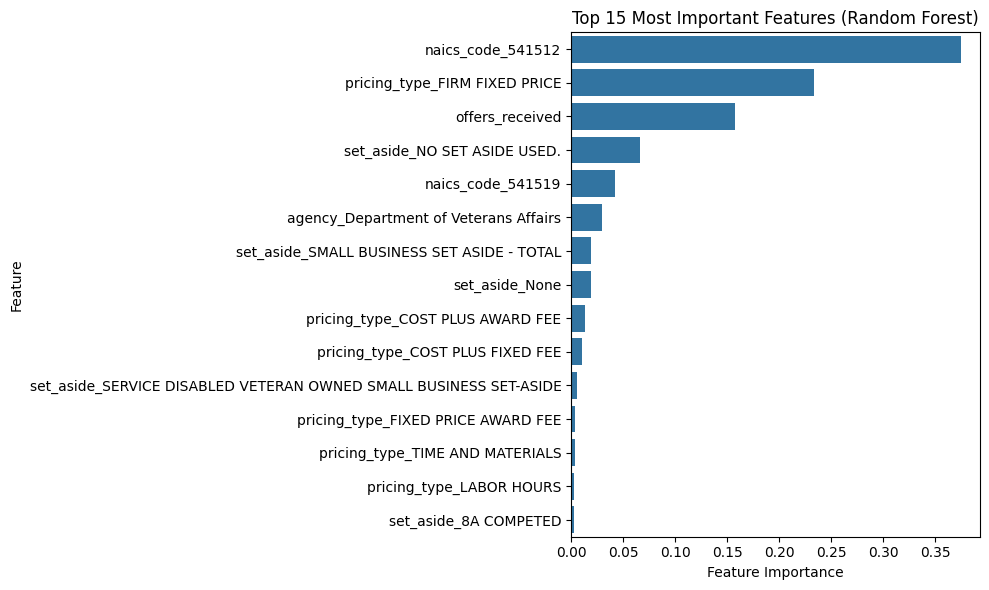

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
features = X_train.columns

# Create a sorted DataFrame
feature_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df.head(15), x="importance", y="feature")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Display all features and their importance scores, sorted
feature_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Show top N or full list
print(feature_df.to_string(index=False))


                                                                    feature  importance
                                                          naics_code_541512    0.374173
                                              pricing_type_FIRM FIXED PRICE    0.233593
                                                            offers_received    0.157544
                                               set_aside_NO SET ASIDE USED.    0.066081
                                                          naics_code_541519    0.042002
                                      agency_Department of Veterans Affairs    0.029270
                                 set_aside_SMALL BUSINESS SET ASIDE - TOTAL    0.018879
                                                             set_aside_None    0.018834
                                           pricing_type_COST PLUS AWARD FEE    0.013460
                                           pricing_type_COST PLUS FIXED FEE    0.010046
          set_aside_SERVICE DISA

SIMPLIFIED FEATURE SET AND LEADERBOARD LOG

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Define top-performing features (from previous importance output)
top_features = [
    'naics_code_541512',
    'naics_code_541519',
    'pricing_type_FIRM FIXED PRICE',
    'pricing_type_COST PLUS AWARD FEE',
    'pricing_type_COST PLUS FIXED FEE',
    'offers_received',
    'set_aside_NO SET ASIDE USED.',
    'set_aside_SMALL BUSINESS SET ASIDE - TOTAL',
    'agency_Department of Veterans Affairs'
]

# Step 2: Subset data
X_top = df_encoded[top_features]
y_top = df_encoded['log_award_amount']

# Step 3: Train/test split
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y_top, test_size=0.2, random_state=42
)

# Step 4: Train model
model_top = RandomForestRegressor(n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train_top)

# Predict and evaluate
y_pred_top = model_top.predict(X_test_top)
rmse_top = mean_squared_error(y_test_top, y_pred_top) ** 0.5
r2_top = r2_score(y_test_top, y_pred_top)

print(f"RMSE (Top Features): {rmse_top:.2f}")
print(f"R² Score (Top Features): {r2_top:.2f}")

# Step 5: Add to leaderboard
new_row_top = pd.DataFrame([{
    "Model": "Random Forest (Top Features)",
    "Features": ", ".join(top_features),
    "RMSE": round(rmse_top, 2),
    "R2": round(r2_top, 2),
    "Notes": "Simplified model using only top 9 features from full RF"
}])

leaderboard = pd.concat([leaderboard, new_row_top], ignore_index=True)
leaderboard.sort_values(by="R2", ascending=False)


RMSE (Top Features): 1.73
R² Score (Top Features): 0.33


,Model,Features,RMSE,R2,Notes
0,Random Forest v1,"Log(target), One-hot (NAICS, set_aside, agency...",1.72,0.34,Baseline model with full categorical encoding
1,Random Forest (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.73,0.33,Simplified model using only top 9 features fro...


Partial Dependence Plot

In [ ]:
!pip install --quiet scikit-learn pandas matplotlib


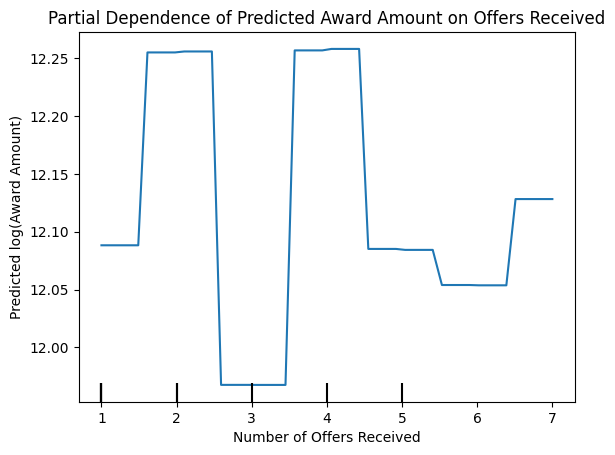

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot PDP for offers_received
PartialDependenceDisplay.from_estimator(
    model_top,          # Your trained model
    X_top,              # Your feature data
    features=['offers_received'],  # Feature(s) to visualize
    kind='average',     # Average effect across all samples
    grid_resolution=50, # How many x-points to evaluate
    n_jobs=-1           # Use all cores
)

plt.title("Partial Dependence of Predicted Award Amount on Offers Received")
plt.xlabel("Number of Offers Received")
plt.ylabel("Predicted log(Award Amount)")
plt.show()


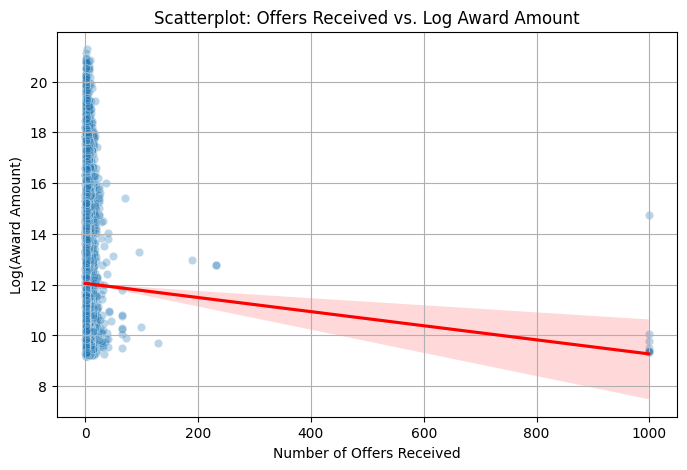

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='offers_received', y='log_award_amount', alpha=0.3)
sns.regplot(data=df, x='offers_received', y='log_award_amount', scatter=False, color='red')

plt.title("Scatterplot: Offers Received vs. Log Award Amount")
plt.xlabel("Number of Offers Received")
plt.ylabel("Log(Award Amount)")
plt.grid(True)
plt.show()


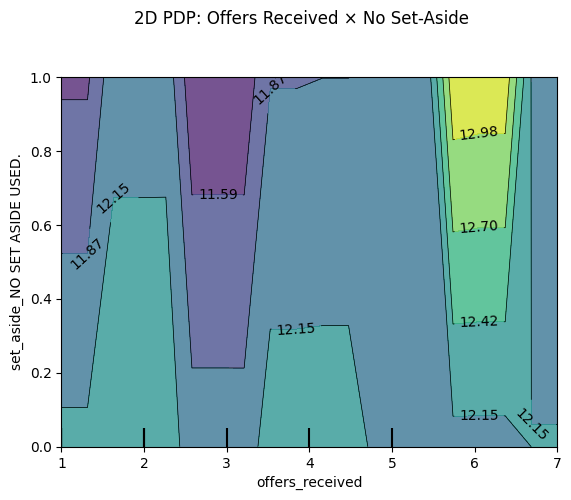

In [ ]:
PartialDependenceDisplay.from_estimator(
    model_top,
    X_top,
    features=[('offers_received', 'set_aside_NO SET ASIDE USED.')],
    kind='average',
    grid_resolution=20
)
plt.suptitle("2D PDP: Offers Received × No Set-Aside", y=1.02)
plt.show()


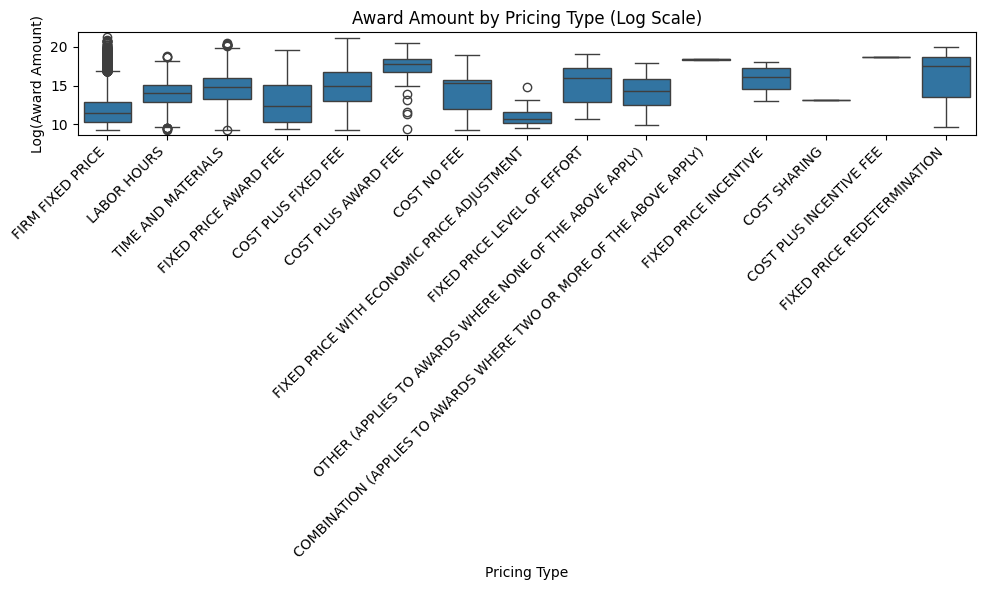

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='pricing_type', y='log_award_amount')
plt.xticks(rotation=45, ha='right')
plt.title("Award Amount by Pricing Type (Log Scale)")
plt.xlabel("Pricing Type")
plt.ylabel("Log(Award Amount)")
plt.tight_layout()
plt.show()


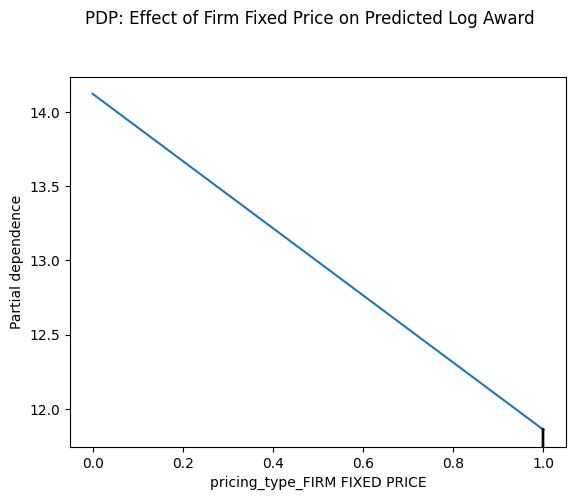

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model_top,
    X_top,
    features=['pricing_type_FIRM FIXED PRICE'],
    kind='average'
)
plt.suptitle("PDP: Effect of Firm Fixed Price on Predicted Log Award", y=1.02)
plt.show()


###SHAP (SHapley Additive exPlanations)

In [ ]:
!pip install shap --quiet


In [ ]:
import shap

# Create the explainer for your Random Forest
explainer = shap.Explainer(model_top, X_top)

# Compute SHAP values
shap_values = explainer(X_top)


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
X_top.dtypes

,0
naics_code_541512,bool
naics_code_541519,bool
pricing_type_FIRM FIXED PRICE,bool
pricing_type_COST PLUS AWARD FEE,bool
pricing_type_COST PLUS FIXED FEE,bool
offers_received,int64
set_aside_NO SET ASIDE USED.,bool
set_aside_SMALL BUSINESS SET ASIDE - TOTAL,bool
agency_Department of Veterans Affairs,bool


In [ ]:
X_top = X_top.astype(float)


In [ ]:
import shap

# Create SHAP explainer for the model
explainer = shap.Explainer(model_top, X_top)

# Compute SHAP values
shap_values = explainer(X_top)


100%|===================| 39901/39905 [05:40<00:00]       

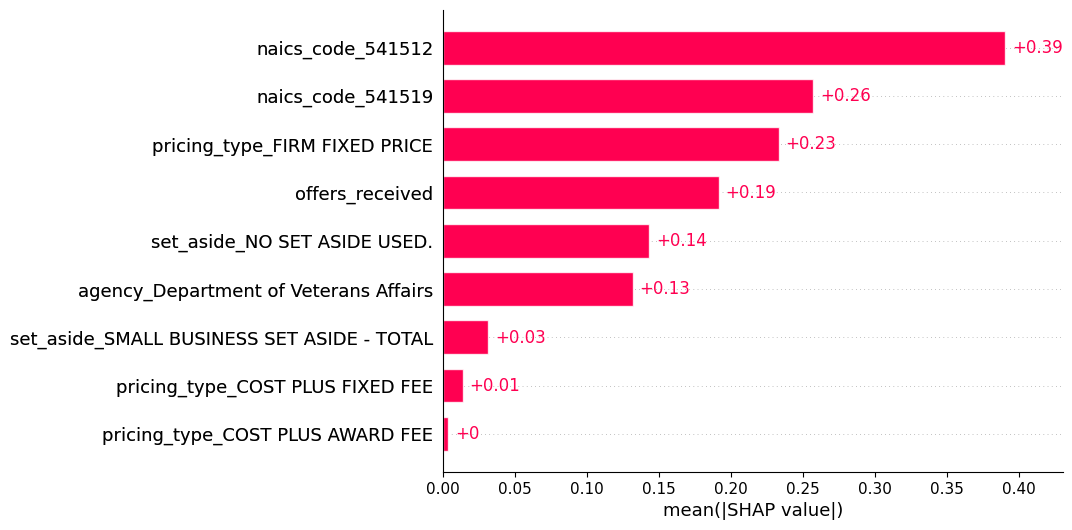

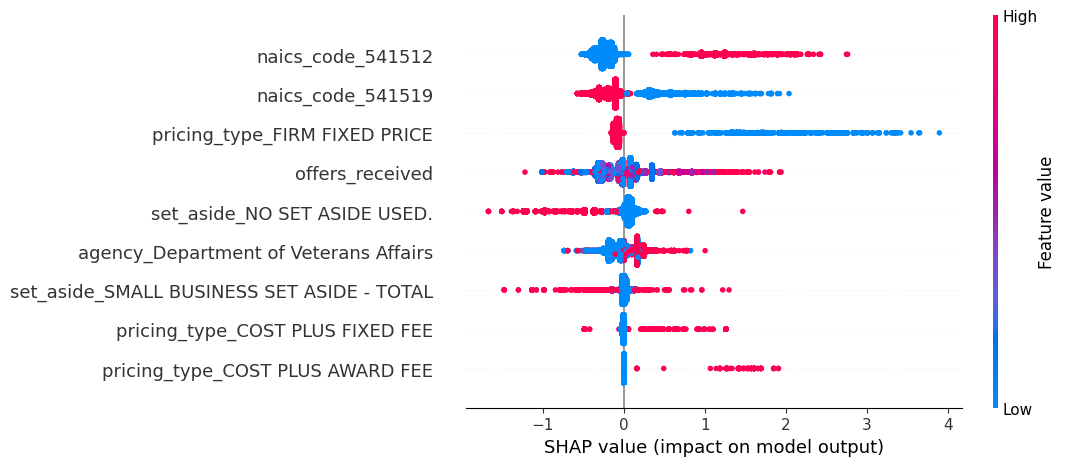

In [ ]:
# Bar chart: mean absolute SHAP value (global feature importance)
shap.plots.bar(shap_values)

# Beeswarm plot: feature value × impact on prediction
shap.plots.beeswarm(shap_values)


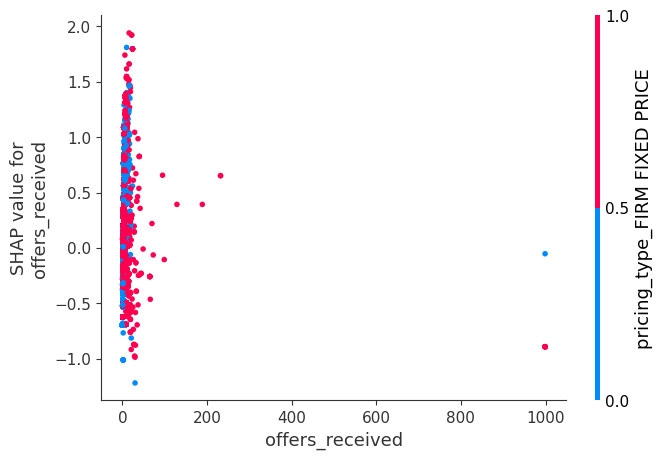

In [ ]:
shap.dependence_plot(
    ind='offers_received',         # Main feature
    shap_values=shap_values.values,
    features=X_top,
    interaction_index='pricing_type_FIRM FIXED PRICE'  # Secondary feature for color
)


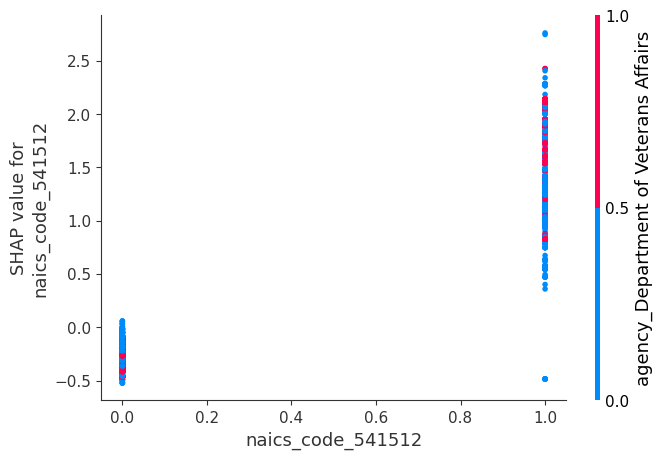

In [ ]:
shap.dependence_plot(
    ind='naics_code_541512',
    shap_values=shap_values.values,
    features=X_top,
    interaction_index='agency_Department of Veterans Affairs'
)


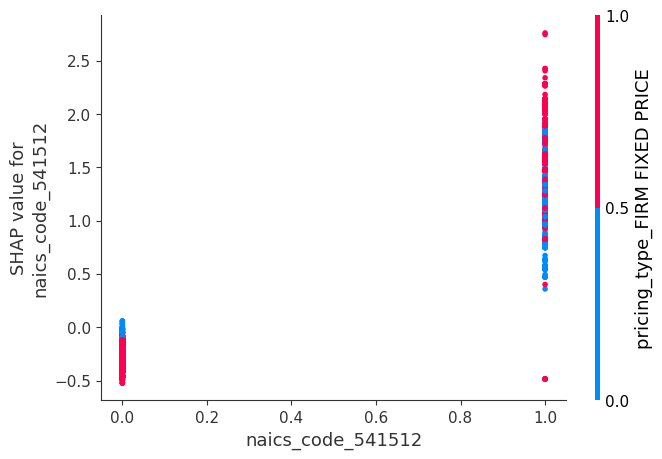

In [ ]:
shap.dependence_plot(
    ind='naics_code_541512',
    shap_values=shap_values.values,
    features=X_top,
    interaction_index='pricing_type_FIRM FIXED PRICE'
)


###XG Boost

In [ ]:
!pip install xgboost --quiet


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# Fit model
xgb_model.fit(X_train_top, y_train_top)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_top)
rmse_xgb = mean_squared_error(y_test_top, y_pred_xgb) ** 0.5
r2_xgb = r2_score(y_test_top, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R² Score: {r2_xgb:.2f}")


XGBoost RMSE: 1.72
XGBoost R² Score: 0.34


In [ ]:
xgb_row = pd.DataFrame([{
    "Model": "XGBoost (Top Features)",
    "Features": ", ".join(X_top.columns),
    "RMSE": round(rmse_xgb, 2),
    "R2": round(r2_xgb, 2),
    "Notes": "XGBoost on top 9 features, default params"
}])

leaderboard = pd.concat([leaderboard, xgb_row], ignore_index=True)
leaderboard.sort_values(by="R2", ascending=False)


,Model,Features,RMSE,R2,Notes
0,Random Forest v1,"Log(target), One-hot (NAICS, set_aside, agency...",1.72,0.34,Baseline model with full categorical encoding
2,XGBoost (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.72,0.34,"XGBoost on top 9 features, default params"
1,Random Forest (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.73,0.33,Simplified model using only top 9 features fro...


✅ Step-by-Step: XGBoost Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}


In [ ]:
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,  # number of combinations to try
    scoring='neg_root_mean_squared_error',  # because we're using RMSE
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_top, y_train_top)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=25,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 6, 8],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
best_xgb = random_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test_top)
rmse_tuned = mean_squared_error(y_test_top, y_pred_tuned) ** 0.5
r2_tuned = r2_score(y_test_top, y_pred_tuned)

print(f"Tuned XGBoost RMSE: {rmse_tuned:.2f}")
print(f"Tuned XGBoost R² Score: {r2_tuned:.2f}")


Tuned XGBoost RMSE: 1.72
Tuned XGBoost R² Score: 0.34


In [ ]:
xgb_tuned_row = pd.DataFrame([{
    "Model": "XGBoost (Tuned Top Features)",
    "Features": ", ".join(X_top.columns),
    "RMSE": round(rmse_tuned, 2),
    "R2": round(r2_tuned, 2),
    "Notes": f"Tuned via RandomizedSearchCV: {random_search.best_params_}"
}])

leaderboard = pd.concat([leaderboard, xgb_tuned_row], ignore_index=True)
leaderboard.sort_values(by="R2", ascending=False)


,Model,Features,RMSE,R2,Notes
0,Random Forest v1,"Log(target), One-hot (NAICS, set_aside, agency...",1.72,0.34,Baseline model with full categorical encoding
2,XGBoost (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.72,0.34,"XGBoost on top 9 features, default params"
3,XGBoost (Tuned Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.72,0.34,Tuned via RandomizedSearchCV: {'subsample': 0....
1,Random Forest (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.73,0.33,Simplified model using only top 9 features fro...


In [ ]:
# Use all encoded columns except those not usable for training
X_full = df_encoded.drop(columns=[
    'award_id', 'recipient', 'naics_description', 'award_amount',
    'log_award_amount', 'start_date', 'end_date', 'state'
])
y_full = df_encoded['log_award_amount']


In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_full = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_full.fit(X_train_full, y_train_full)

# Predict + evaluate
y_pred_full = xgb_full.predict(X_test_full)
rmse_full = mean_squared_error(y_test_full, y_pred_full) ** 0.5
r2_full = r2_score(y_test_full, y_pred_full)

print(f"XGBoost Full RMSE: {rmse_full:.2f}")
print(f"XGBoost Full R² Score: {r2_full:.2f}")


XGBoost Full RMSE: 1.71
XGBoost Full R² Score: 0.35


In [ ]:
xgb_full_row = pd.DataFrame([{
    "Model": "XGBoost (Full Features)",
    "Features": f"{X_full.shape[1]} features",
    "RMSE": round(rmse_full, 2),
    "R2": round(r2_full, 2),
    "Notes": "Full feature set, manually tuned parameters"
}])

leaderboard = pd.concat([leaderboard, xgb_full_row], ignore_index=True)
leaderboard.sort_values(by="R2", ascending=False)


,Model,Features,RMSE,R2,Notes
4,XGBoost (Full Features),36 features,1.71,0.35,"Full feature set, manually tuned parameters"
0,Random Forest v1,"Log(target), One-hot (NAICS, set_aside, agency...",1.72,0.34,Baseline model with full categorical encoding
2,XGBoost (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.72,0.34,"XGBoost on top 9 features, default params"
3,XGBoost (Tuned Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.72,0.34,Tuned via RandomizedSearchCV: {'subsample': 0....
1,Random Forest (Top Features),"naics_code_541512, naics_code_541519, pricing_...",1.73,0.33,Simplified model using only top 9 features fro...


###Save Model in Streamlit

In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load model and column structure
model = joblib.load("xgb_federal_award_model.pkl")
feature_cols = joblib.load("xgb_feature_columns.pkl")


In [ ]:
# One-hot encoded input matching your feature set
sample = {
    'naics_code_541512': 1,
    'naics_code_541519': 0,
    'pricing_type_FIRM FIXED PRICE': 1,
    'pricing_type_COST PLUS AWARD FEE': 0,
    'pricing_type_COST PLUS FIXED FEE': 0,
    'offers_received': 3,
    'set_aside_NO SET ASIDE USED.': 1,
    'set_aside_SMALL BUSINESS SET ASIDE - TOTAL': 0,
    'agency_Department of Veterans Affairs': 1,
    # All other one-hot columns set to 0
}

# Ensure all missing columns are included
input_df = pd.DataFrame([{col: sample.get(col, 0) for col in feature_cols}])


In [ ]:
predicted_log = model.predict(input_df)
predicted_amount = np.expm1(predicted_log[0])

print(f"Predicted Award Amount: ${predicted_amount:,.2f}")


Predicted Award Amount: $1,155,600.62


In [ ]:
streamlit_code = '''\
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# --- Load model and feature columns ---
model = joblib.load("xgb_federal_award_model.pkl")
feature_cols = joblib.load("xgb_feature_columns.pkl")

st.title("Federal Health IT Bid Amount Predictor")
st.write("Estimate the award amount for a federal Health IT contract based on contract features.")

# --- User Inputs ---
st.header("Enter Contract Details")

naics_code = st.selectbox("NAICS Code", ["541511", "541512", "541519"])
pricing_type = st.selectbox("Pricing Type", [
    "FIRM FIXED PRICE",
    "COST PLUS AWARD FEE",
    "COST PLUS FIXED FEE"
])
offers_received = st.slider("Number of Offers Received", min_value=1, max_value=10, value=3)
set_aside = st.selectbox("Set-Aside Type", [
    "NO SET ASIDE USED.",
    "SMALL BUSINESS SET ASIDE - TOTAL"
])
is_va = st.checkbox("Department of Veterans Affairs is the awarding agency")

# --- Build Input Row ---
input_data = {col: 0 for col in feature_cols}

# Map inputs to the right one-hot columns
input_data[f"naics_code_{naics_code}"] = 1
input_data[f"pricing_type_{pricing_type}"] = 1
input_data["offers_received"] = offers_received
input_data[f"set_aside_{set_aside}"] = 1
if is_va:
    input_data["agency_Department of Veterans Affairs"] = 1

input_df = pd.DataFrame([input_data])

# --- Predict and Show Result ---
if st.button("Predict Award Amount"):
    predicted_log = model.predict(input_df)
    predicted_amount = np.expm1(predicted_log[0])
    st.success(f"Estimated Award Amount: ${predicted_amount:,.2f}")
'''

# Save to file
with open("app.py", "w") as f:
    f.write(streamlit_code)


In [ ]:
!cp /content/drive/MyDrive/federal-bid-prediction/outputs/app.py .
!cp /content/drive/MyDrive/federal-bid-prediction/outputs/xgb_federal_award_model.pkl .
!cp /content/drive/MyDrive/federal-bid-prediction/outputs/xgb_feature_columns.pkl .


In [ ]:
from google.colab import files
files.download("app.py")
files.download("xgb_federal_award_model.pkl")
files.download("xgb_feature_columns.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>